# Hotel Cancellation - Data Preprocessing and EDA

### Import libraries

In [1]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
from matplotlib import pyplot as plt

import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from sklearn.model_selection import train_test_split
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# !pip install gdown
import gdown
import os

sklearn.__version__

'1.2.2'

### Read in data and data preprocessing

In [2]:
def download_and_read_in_data(url):
    output_file = 'Hotel_Reservations.csv'
    gdown.download(url, output_file, quiet=True)
    df = pd.read_csv(output_file)

    # clean up the temporary file
    os.remove(output_file)
    return df

url_0 = 'https://drive.google.com/file/d/1wOwHx7T68HTX7V_-5ejhMNqeiPOYz4v3/view?usp=drive_link'
file_id = url_0.split('/')[-2]
url = f'https://drive.google.com/uc?id={file_id}'
df_0 = download_and_read_in_data(url)
df_0.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [14]:
# Understand the data
# check the shape
print (f'The shape of the data is {df_0.shape}.')

# check column names
print (f'\nThe column names are {df_0.columns.tolist()}')

# check the null value
print ('\nCheck the null value:')
display(df_0.isnull().sum())

# check the data type
print ('\nCheck the overall column info and data types:')
display(df_0.info())

# Check each column's unique values
print ('\nCheck each column unique value:')
for col in df_0.columns:
    print ('For column - '+col+':')
    display(df_0[col].value_counts().sort_values(ascending=False))

# Check the validity of dates

test2 = pd.to_datetime(df_0[['arrival_year', 'arrival_month', 'arrival_date']].rename(columns={'arrival_year':'year', 'arrival_month':'month', 'arrival_date':'day'}), \
                       errors='coerce')
test3 = pd.to_datetime(df_0[['arrival_year', 'arrival_month', 'arrival_date']].rename(columns={'arrival_year':'year', 'arrival_month':'month', 'arrival_date':'day'}), \
                        errors='ignore')
print ('Found some invalid dates:')
display(test3[test2.isnull()])

# fixed date by move it to the previous valid date
df_0.loc[(df_0['arrival_year']==2018)&(df_0['arrival_month']==2)&(df_0['arrival_date']==29), 'arrival_date'] = 28

# Comments on data cleaning
print ('Based on the initial screening of the data, we did not find much obvious data issues except for one invalid date, more specifically:')
print ('From what we can observe, ')
print ('(1). the data does not have missing values, ')
print ('(2). each column contains values which are reasonable within the context, ')
print ('(3). we did not find repetitive data. Each entry can be uniquely defined by Booking_ID.')
print ('(4). we found one invalid date: 2/29/2018 with 5 entries, which we decided to move it to 2/28/2018.')
print ('Thus we are not performing further editing to fix any data based on this evaluation.')
print ('But we decided to exclude Booking_ID and arrival_year, because booking ID is just identification number, and arrival year is a feature ')
print ('unlikely to be repeated in unseen data ')

The shape of the data is (36275, 19).

The column names are ['Booking_ID', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'market_segment_type', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests', 'booking_status']

Check the null value:


Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64


Check the overall column info and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                      

None


Check each column unique value:
For column - Booking_ID:


Booking_ID
INN00001    1
INN00007    1
INN00070    1
INN00009    1
INN00003    1
           ..
INN36262    1
INN36261    1
INN36267    1
INN36242    1
INN36275    1
Name: count, Length: 36275, dtype: int64

For column - no_of_adults:


no_of_adults
2    26108
1     7695
3     2317
0      139
4       16
Name: count, dtype: int64

For column - no_of_children:


no_of_children
0     33577
1      1618
2      1058
3        19
9         2
10        1
Name: count, dtype: int64

For column - no_of_weekend_nights:


no_of_weekend_nights
0    16872
1     9995
2     9071
3      153
4      129
5       34
6       20
7        1
Name: count, dtype: int64

For column - no_of_week_nights:


no_of_week_nights
2     11444
1      9488
3      7839
4      2990
0      2387
5      1614
6       189
7       113
8        62
10       62
9        34
11       17
15       10
12        9
14        7
13        5
17        3
16        2
Name: count, dtype: int64

For column - type_of_meal_plan:


type_of_meal_plan
Meal Plan 1     27835
Not Selected     5130
Meal Plan 2      3305
Meal Plan 3         5
Name: count, dtype: int64

For column - required_car_parking_space:


required_car_parking_space
0    35151
1     1124
Name: count, dtype: int64

For column - room_type_reserved:


room_type_reserved
Room_Type 1    28130
Room_Type 4     6057
Room_Type 6      966
Room_Type 2      692
Room_Type 5      265
Room_Type 7      158
Room_Type 3        7
Name: count, dtype: int64

For column - lead_time:


lead_time
0      1297
1      1078
2       643
3       630
4       628
       ... 
348       1
345       1
350       1
325       1
351       1
Name: count, Length: 352, dtype: int64

For column - arrival_year:


arrival_year
2018    29761
2017     6514
Name: count, dtype: int64

For column - arrival_month:


arrival_month
10    5317
9     4611
8     3813
6     3203
12    3021
11    2980
7     2920
4     2736
5     2598
3     2358
2     1704
1     1014
Name: count, dtype: int64

For column - arrival_date:


arrival_date
13    1358
17    1345
2     1331
4     1327
19    1327
16    1306
20    1281
15    1273
6     1273
18    1260
14    1242
30    1216
12    1204
8     1198
29    1190
21    1158
5     1154
26    1146
25    1146
1     1133
9     1130
28    1129
7     1110
24    1103
11    1098
3     1098
10    1089
27    1059
22    1023
23     990
31     578
Name: count, dtype: int64

For column - market_segment_type:


market_segment_type
Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: count, dtype: int64

For column - repeated_guest:


repeated_guest
0    35345
1      930
Name: count, dtype: int64

For column - no_of_previous_cancellations:


no_of_previous_cancellations
0     35937
1       198
2        46
3        43
11       25
5        11
4        10
13        4
6         1
Name: count, dtype: int64

For column - no_of_previous_bookings_not_canceled:


no_of_previous_bookings_not_canceled
0     35463
1       228
2       112
3        80
4        65
5        60
6        36
7        24
8        23
10       19
9        19
11       15
12       12
14        9
15        8
13        7
16        7
18        6
20        6
21        6
17        6
19        6
22        6
25        3
27        3
24        3
23        3
26        2
31        2
30        2
32        2
48        2
28        2
44        2
29        2
56        1
47        1
49        1
52        1
39        1
34        1
38        1
51        1
42        1
37        1
33        1
35        1
50        1
43        1
40        1
41        1
58        1
54        1
53        1
57        1
45        1
55        1
46        1
36        1
Name: count, dtype: int64

For column - avg_price_per_room:


avg_price_per_room
65.00     848
75.00     826
90.00     703
95.00     669
115.00    662
         ... 
103.86      1
129.83      1
246.60      1
86.85       1
167.80      1
Name: count, Length: 3930, dtype: int64

For column - no_of_special_requests:


no_of_special_requests
0    19777
1    11373
2     4364
3      675
4       78
5        8
Name: count, dtype: int64

For column - booking_status:


booking_status
Not_Canceled    24390
Canceled        11885
Name: count, dtype: int64

Found some invalid dates:


2626     20180229
3677     20180229
5600     20180229
6343     20180229
7648     20180229
8000     20180229
8989     20180229
9153     20180229
9245     20180229
9664     20180229
9934     20180229
10593    20180229
10652    20180229
10747    20180229
11881    20180229
13958    20180229
14304    20180229
15363    20180229
15438    20180229
17202    20180229
18380    20180229
18534    20180229
18680    20180229
19013    20180229
20419    20180229
21674    20180229
21688    20180229
26108    20180229
27559    20180229
27928    20180229
30552    20180229
30616    20180229
30632    20180229
30839    20180229
32041    20180229
34638    20180229
35481    20180229
dtype: object

Based on the initial screening of the data, we did not find much obvious data issues except for one invalid date, more specifically:
From what we can observe, 
(1). the data does not have missing values, 
(2). each column contains values which are reasonable within the context, 
(3). we did not find repetitive data. Each entry can be uniquely defined by Booking_ID.
(4). we found one invalid date: 2/29/2018 with 5 entries, which we decided to move it to 2/28/2018.
Thus we are not performing further editing to fix any data based on this evaluation.
But we decided to exclude Booking_ID and arrival_year, because booking ID is just identification number, and arrival year is a feature 
unlikely to be repeated in unseen data 


### </span> Define the task and necessary feature engineering

Note: our task is to use appropriate features to predict if a client will cancel the reservation or not; Therefore our outcome variable is 'booking_status'

Feature engineering: in order to process the label using ML, we decided to change booking_status to one_hot encoding

In [15]:
# To save the original data as it is, use a copy to process further changes
df_used = df_0.copy()

# In order to process the label using ML, change booking_status to one_hot encoding:
df_used.loc[df_used['booking_status']=='Canceled', 'booking_status'] = 1.0
df_used.loc[df_used['booking_status']=='Not_Canceled', 'booking_status'] = 0.0
df_used['booking_status'] = df_used['booking_status'].astype('category')

print ('The unique values of booking_status after changing to 1 and 0 are:')
display(df_used['booking_status'].value_counts())
display(df_used['booking_status'].describe())
print ('\nNote that given the booking status for value 0 is more than two times of the value 1, we may need to apply oversampling techniques on training data to help with data imbalance issue.')

# Add a derived feature - week of day (0: Monday; 6: Sunday)
df_used['arrival_week_of_day'] = pd.to_datetime(df_used[['arrival_year', 'arrival_month', 'arrival_date']].\
                                            rename(columns={'arrival_year':'year', 'arrival_month':'month', 'arrival_date':'day'}),  errors='coerce')\
                                                .apply(lambda x: x.weekday())

# Group very low count subgroups in no_of_children, effectively change them from numerical to label encoding
# df_used.loc[df_used['no_of_adults']>=3, 'no_of_adults'] = 3
df_used.loc[df_used['no_of_children']>=3, 'no_of_children'] = 3

print ('\nAfter merging small count sub groups, no of children value counts are as below:')
# display(df_used['no_of_adults'].value_counts())
display(df_used['no_of_children'].value_counts())

# Treat different types of features seperately, for now treat the categorical features as categorical in pandas first

numeric_features = ['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'lead_time',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests']

excluded_features = ['Booking_ID', 'arrival_year'] 
cat_features = ['type_of_meal_plan', 
                'room_type_reserved',  
                'market_segment_type', 
                'repeated_guest', 
                'required_car_parking_space', 
                'arrival_month', 
                'arrival_date', 
                'arrival_week_of_day']

print ('Before changing the type of variables:')
display(df_used[cat_features].describe())

df_used[cat_features] = df_used[cat_features].astype('category')
print ('After changing the type of variables:')
display(df_used[cat_features].describe())


The unique values of booking_status after changing to 1 and 0 are:


booking_status
0.0    24390
1.0    11885
Name: count, dtype: int64

count     36275.0
unique        2.0
top           0.0
freq      24390.0
Name: booking_status, dtype: float64


Note that given the booking status for value 0 is more than two times of the value 1, we may need to apply oversampling techniques on training data to help with data imbalance issue.

After merging small count sub groups, no of children value counts are as below:


no_of_children
0    33577
1     1618
2     1058
3       22
Name: count, dtype: int64

Before changing the type of variables:


,repeated_guest,required_car_parking_space,arrival_month,arrival_date,arrival_week_of_day
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,0.025637,0.030986,7.423653,15.595975,3.079642
std,0.158053,0.173281,3.069894,8.738941,2.064295
min,0.000000,0.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,5.000000,8.000000,1.000000
50%,0.000000,0.000000,8.000000,16.000000,3.000000
75%,0.000000,0.000000,10.000000,23.000000,5.000000
max,1.000000,1.000000,12.000000,31.000000,6.000000


After changing the type of variables:


,type_of_meal_plan,room_type_reserved,market_segment_type,repeated_guest,required_car_parking_space,arrival_month,arrival_date,arrival_week_of_day
count,36275,36275,36275,36275,36275,36275,36275,36275
unique,4,7,5,2,2,12,31,7
top,Meal Plan 1,Room_Type 1,Online,0,0,10,13,6
freq,27835,28130,23214,35345,35151,5317,1358,6135


### </span> Split the data

Note: although we have 2017 and 2018 data by arrival date, given the booking ID is likely orderd by the time the booking was made, and considering the business context, we assume that there is no time trend and the 2017 and 2018 record can be considered a snapshot of the same period. Thus we will treat them as cross sectional data.

In [16]:
# Shuffle the dataset

np.random.seed(1234)
df_used = df_used.reindex(np.random.permutation(range(df_used.shape[0])))
print ('First a few rows of the dataset after shuffling:')
display(df_used.head())

# Spliting the data (aiming for train:validation:test split = 0.6:0.2:0.2)
X = df_used.drop(columns=['booking_status']).drop(columns=excluded_features)
Y = df_used['booking_status']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1234, test_size=0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=1234, test_size=0.25)

print (f'After shuffling and spliting the data, the shape of training data sets are: X_train: {X_train.shape}, Y_train: {Y_train.shape}.')
print (f'The shape of validation data sets are: X_val: {X_val.shape}, Y_val: {Y_val.shape}.')
print (f'The shape of test data sets are: X_test: {X_test.shape}, Y_test: {Y_test.shape}.')

First a few rows of the dataset after shuffling:


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,arrival_week_of_day
13395,INN13396,1,0,0,1,Not Selected,0,Room_Type 1,0,2018,6,7,Online,1,0,1,109.0,1,0.0,3
34566,INN34567,2,2,0,1,Meal Plan 1,0,Room_Type 6,7,2018,7,29,Online,0,0,0,201.0,1,0.0,6
19339,INN19340,1,0,0,1,Meal Plan 1,0,Room_Type 4,9,2018,12,7,Online,0,0,0,114.0,1,0.0,4
33485,INN33486,1,0,0,1,Meal Plan 1,0,Room_Type 1,1,2018,1,7,Corporate,1,0,3,65.0,0,0.0,6
24837,INN24838,2,0,0,1,Not Selected,0,Room_Type 1,207,2018,10,4,Online,0,0,0,98.1,0,1.0,3


After shuffling and spliting the data, the shape of training data sets are: X_train: (21765, 17), Y_train: (21765,).
The shape of validation data sets are: X_val: (7255, 17), Y_val: (7255,).
The shape of test data sets are: X_test: (7255, 17), Y_test: (7255,).


### Exploratory data analysis (EDA) - on train data only

The numerical variables data summary is as below:


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,21765.000000,21765.000000,21765.000000,21765.000000,21765.000000,21765.000000,21765.000000,21765.000000,21765.000000
mean,1.848932,0.104388,0.810935,2.198438,85.226235,0.023524,0.154514,103.408723,0.618792
std,0.518952,0.391911,0.867721,1.396887,85.542961,0.371268,1.796141,34.866077,0.786129
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,17.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,57.000000,0.000000,0.000000,99.480000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,127.000000,0.000000,0.000000,120.600000,1.000000
max,4.000000,3.000000,7.000000,17.000000,443.000000,13.000000,58.000000,540.000000,5.000000


The categorical variables data summary is as below:


,type_of_meal_plan,room_type_reserved,market_segment_type,repeated_guest,required_car_parking_space,arrival_month,arrival_date,arrival_week_of_day,booking_status
count,21765,21765,21765,21765,21765,21765,21765,21765,21765.0
unique,4,7,5,2,2,12,31,7,2.0
top,Meal Plan 1,Room_Type 1,Online,0,0,10,19,6,0.0
freq,16679,16877,14004,21225,21085,3137,831,3680,14608.0


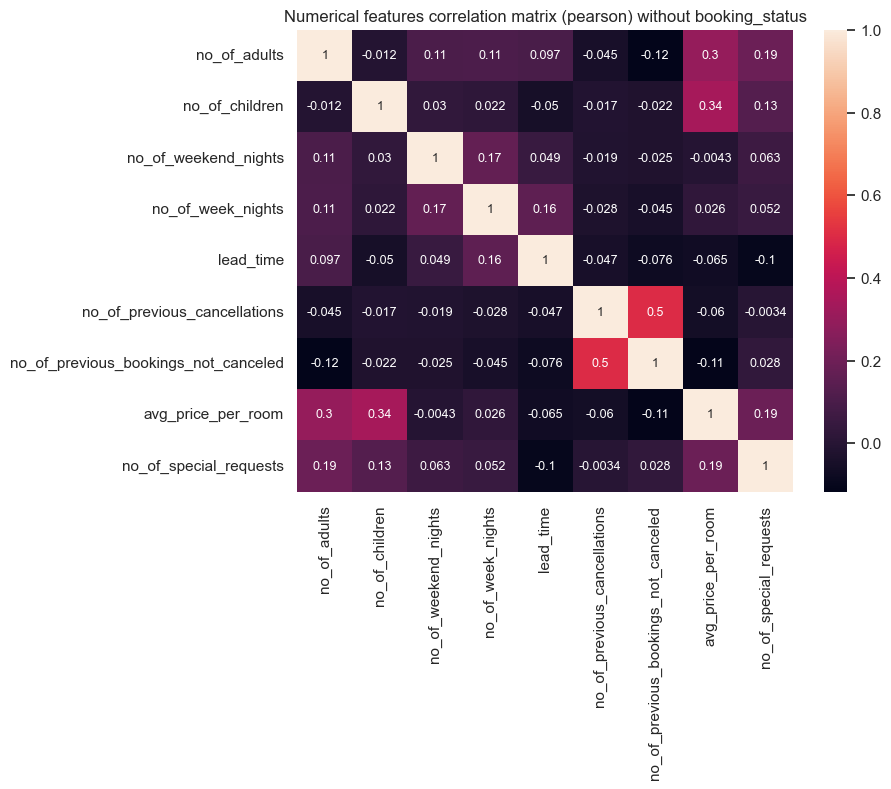

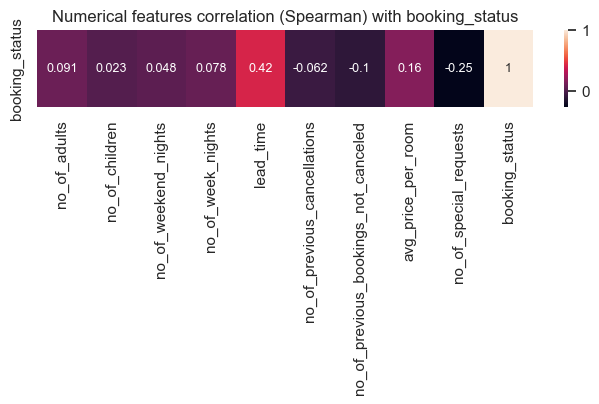

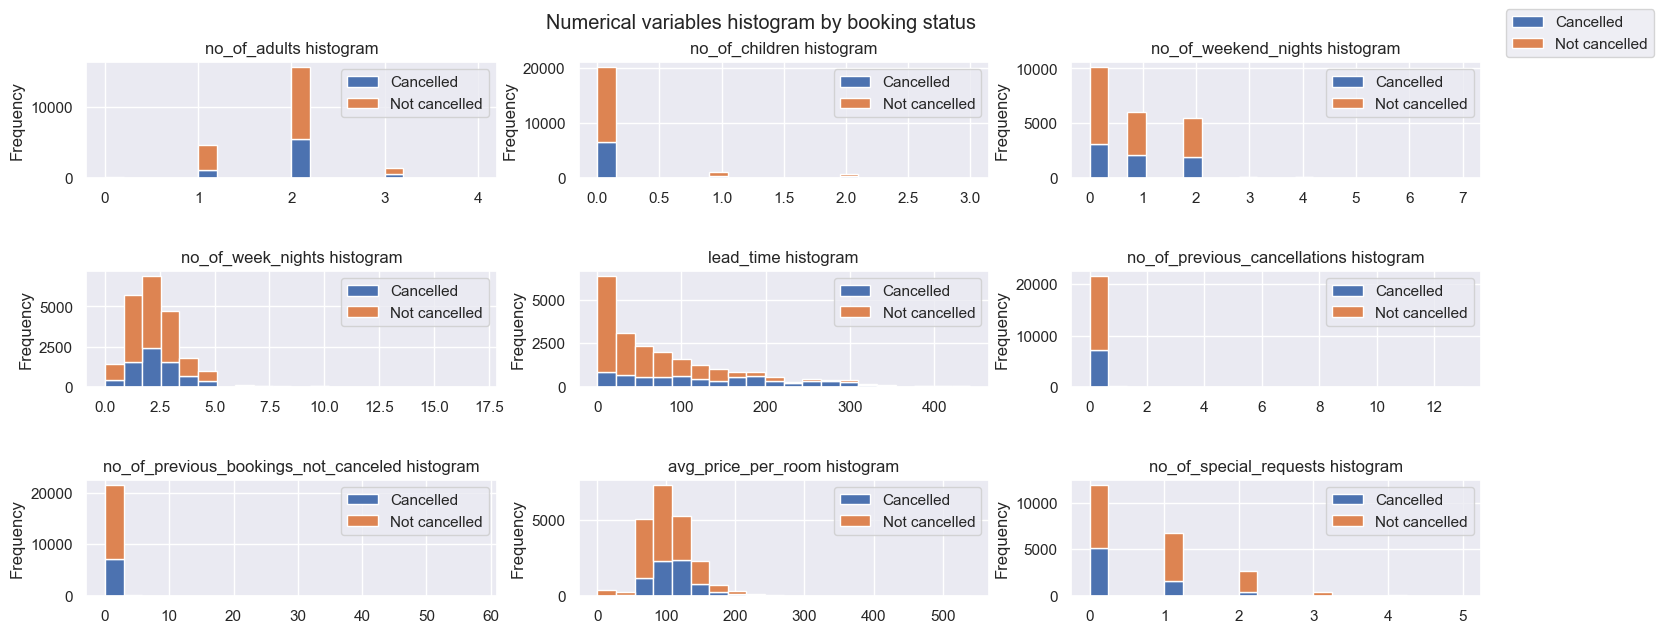

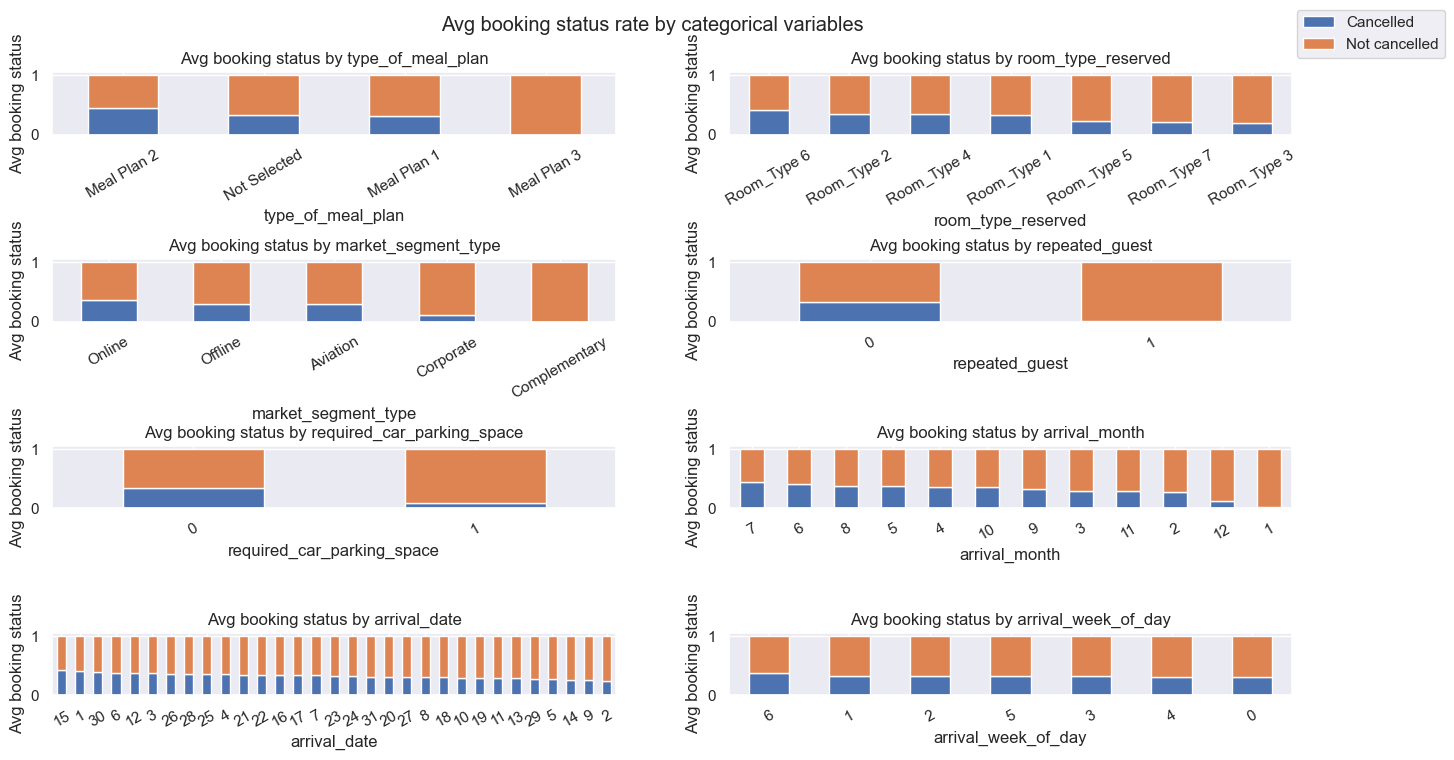

Based on the EDA on training data, we noted that:
(1). the pair-wise correlation between booking status and other numerical variables are relatively weak. The variables with highest correlations with booking status are:
lead time, no_of_special_request, avg_price_per_room.
(2). We can see that the counts of booking status could vary meaningfully by different categorical variables.
At this point, we decided to keep most of the features except for Booking_ID for modeling, but in order for ML to process categorical inputs, 
we will change the categorical inputs into dummy variables.


In [17]:
df_train_num = X_train[numeric_features]
df_train_cat = pd.concat([X_train[cat_features], Y_train.astype(float)], axis=1)

# data summary:
print ('The numerical variables data summary is as below:')
display(df_train_num.describe())

print ('The categorical variables data summary is as below:')
display(df_train_cat.astype('category').describe())

# numerical values' pearson correlation matrix among themselves
cm = X_train[numeric_features].corr(method='pearson')
plt.figure(figsize=(8,6))
hm = sns.heatmap(cm, annot=True, annot_kws={'size': 9})
plt.title('Numerical features correlation matrix (pearson) without booking_status')
plt.show()

# numercial values' spearman correlation with target varable (cancellation or not)
df_train_num_plus_Y = pd.concat([X_train[numeric_features], Y_train], axis=1)
cm = df_train_num_plus_Y.corr(method='spearman')['booking_status'].to_frame().T
plt.figure(figsize=(8,1))
hm = sns.heatmap(cm, annot=True, annot_kws={'size': 9})
plt.title('Numerical features correlation (Spearman) with booking_status')
plt.show()

# numerical values' histogram (conditional on booking status)
fig1, ax1 = plt.subplots(3,3,figsize=(18,6))
i = 0
for col in numeric_features:

    df_temp = pd.concat([df_train_num_plus_Y[df_train_num_plus_Y['booking_status']==1.0][col].rename('Cancelled'), \
           df_train_num[df_train_num_plus_Y['booking_status']==0.0][col].rename('Not cancelled')], axis=1)
    df_temp.plot(ax=ax1[i//3,i%3],kind='hist', stacked=True, bins=20)

    ax1[i//3,i%3].set_title(col + ' histogram')
    # ax1[i//3,i%3].set_ylabel('Counts')
    # ax1[i//3,i%3].set_xticklabels(df_temp.index, rotation=30)
    i+=1
fig1.suptitle('Numerical variables histogram by booking status')
plt.subplots_adjust(top=0.90, bottom=0.01, hspace=0.8)
handles, labels = ax1[0,0].get_legend_handles_labels()
fig1.legend(handles, labels, bbox_to_anchor=(1,1))
plt.show()


# Cancelation probability by categorical variables (conditional on booking status)
fig2, ax2 = plt.subplots(4,2,figsize=(16,7))
i = 0
for col in cat_features:
    df_temp = df_train_cat.groupby(col)['booking_status'].apply(lambda x: pd.concat([x.rename('Cancelled'), (1-x).rename('Not cancelled')], axis=1).mean()).unstack()\
    .sort_values(by='Cancelled', ascending=False)
    df_temp.plot(ax=ax2[i//2,i%2], kind='bar', stacked=True, legend=False)

    ax2[i//2,i%2].set_title('Avg booking status by '+col)
    ax2[i//2,i%2].set_ylabel('Avg booking status')
    ax2[i//2,i%2].set_xticklabels(df_temp.index, rotation=30)
    # ax2[i//2,i%2].set_xticklabels(df_temp[col], rotation=30)
    i+=1
fig2.suptitle('Avg booking status rate by categorical variables')
plt.subplots_adjust(top=0.90, bottom=0.01, hspace=2.0)
handles, labels = ax2[0,0].get_legend_handles_labels()
fig2.legend(handles, labels, bbox_to_anchor=(1,1))
plt.show()


# Preliminary EDA conclusion
print ('Based on the EDA on training data, we noted that:')
print ('(1). the pair-wise correlation between booking status and other numerical variables are relatively weak. The variables with highest correlations with booking status are:')
print ('lead time, no_of_special_request, avg_price_per_room.')
print ('(2). We can see that the counts of booking status could vary meaningfully by different categorical variables.')
print ('At this point, we decided to keep most of the features except for Booking_ID for modeling, but in order for ML to process categorical inputs, ')
print ('we will change the categorical inputs into dummy variables.')

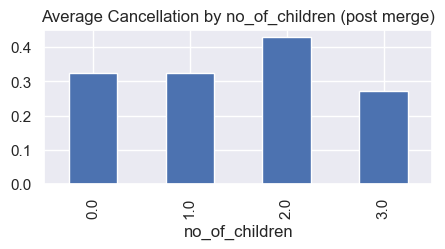

In [18]:
df_train_num_plus_Y.astype(float).groupby('no_of_children')['booking_status'].mean().plot.bar(title='Average Cancellation by no_of_children (post merge)', figsize=(5,2))
plt.show()

### Further Data preprocessing

1. Integrate any supplementary tasks including feature engineering deemed crucial for modeling, especially considering the chosen outcome variable.
2. Standardizing the data

In [19]:
# Features engineering
print ('\nChange the categorical data to one-hot representation for the entire dataset then assign the additonal features to train, validation and test set based on index:')

added_feat = pd.get_dummies(df_used[cat_features], dtype=float)
print ('The added features are as below:')
display(added_feat.describe())

print (f'The shape of X_train before change is {X_train.shape}')
print (f'The shape of X_val before change is {X_val.shape}')
print (f'The shape of X_test before change is {X_test.shape}')

X_train = pd.concat([X_train, added_feat.loc[X_train.index,:]], axis=1).drop(columns=cat_features)
X_val = pd.concat([X_val, added_feat.loc[X_val.index,:]], axis=1).drop(columns=cat_features)
X_test = pd.concat([X_test, added_feat.loc[X_test.index,:]], axis=1).drop(columns=cat_features)

print (f'\nThe shape of X_train after change is {X_train.shape}')
print (f'The shape of X_val after change is {X_val.shape}')
print (f'The shape of X_test after change is {X_test.shape}')

# Standardize data (only numerical features)
X_train_std = X_train.copy()
X_val_std = X_val.copy()
X_test_std = X_test.copy()

X_train_std[numeric_features] = (X_train[numeric_features] - X_train[numeric_features].mean())/X_train[numeric_features].std()
X_val_std[numeric_features] = (X_val[numeric_features] - X_train[numeric_features].mean())/X_train[numeric_features].std()
X_test_std[numeric_features] = (X_test[numeric_features] - X_train[numeric_features].mean())/X_train[numeric_features].std()

print ('Check the description of the post standarization of X_train_std')
display(X_train_std[numeric_features].describe())
display(X_val_std[numeric_features].describe())

print (f'\nThe shape of X_train_std after standarization is {X_train_std.shape}')
print (f'The shape of X_val_std after standarization is {X_val_std.shape}')
print (f'The shape of X_test_std after standarization is {X_test_std.shape}')


# Treat data imbalance
oversample_ob = RandomOverSampler(random_state=1234, sampling_strategy = 'minority')
X_train_std_os, Y_train_os = oversample_ob.fit_resample(X_train_std, Y_train)
# IN: if we do not want to do oversampling
# X_train_std_os, Y_train_os = X_train_std, Y_train

print (f'\nThe shape of X_train_std_os after sample imbalance treatment is {X_train_std_os.shape}')
print (f'The shape of Y_train_os after sample imbalance treatment is {Y_train_os.shape}')
display(Y_train_os.value_counts())

# Change all inputs as numerical for ML to work
X_train_std_os, Y_train_os, X_val_std, Y_val, X_test_std, Y_test = \
    X_train_std_os.astype(float), Y_train_os.astype(float), X_val_std.astype(float), Y_val.astype(float), X_test_std.astype(float), Y_test.astype(float)


Change the categorical data to one-hot representation for the entire dataset then assign the additonal features to train, validation and test set based on index:
The added features are as below:


,type_of_meal_plan_Meal Plan 1,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 1,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,...,arrival_date_29,arrival_date_30,arrival_date_31,arrival_week_of_day_0,arrival_week_of_day_1,arrival_week_of_day_2,arrival_week_of_day_3,arrival_week_of_day_4,arrival_week_of_day_5,arrival_week_of_day_6
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,...,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,0.767333,0.091110,0.000138,0.141420,0.775465,0.019076,0.000193,0.166975,0.007305,0.026630,...,0.031785,0.033522,0.015934,0.148312,0.135052,0.142164,0.125265,0.130696,0.149387,0.169125
std,0.422538,0.287769,0.011740,0.348459,0.417281,0.136796,0.013890,0.372958,0.085159,0.161001,...,0.175430,0.179997,0.125221,0.355413,0.341783,0.349223,0.331024,0.337072,0.356474,0.374867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The shape of X_train before change is (21765, 17)
The shape of X_val before change is (7255, 17)
The shape of X_test before change is (7255, 17)

The shape of X_train after change is (21765, 79)
The shape of X_val after change is (7255, 79)
The shape of X_test after change is (7255, 79)
Check the description of the post standarization of X_train_std


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04,2.176500e+04
mean,-1.111600e-16,1.501721e-17,3.101381e-17,-5.729394e-17,-9.238851e-17,-1.175260e-17,-4.570456e-18,-1.939179e-16,3.362550e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.562819e+00,-2.663556e-01,-9.345568e-01,-1.573812e+00,-9.962975e-01,-6.336118e-02,-8.602559e-02,-2.965883e+00,-7.871379e-01
25%,2.911025e-01,-2.663556e-01,-9.345568e-01,-8.579347e-01,-7.975669e-01,-6.336118e-02,-8.602559e-02,-6.627853e-01,-7.871379e-01
50%,2.911025e-01,-2.663556e-01,2.178868e-01,-1.420572e-01,-3.299656e-01,-6.336118e-02,-8.602559e-02,-1.126804e-01,-7.871379e-01
75%,2.911025e-01,-2.663556e-01,1.370330e+00,5.738203e-01,4.883367e-01,-6.336118e-02,-8.602559e-02,4.930660e-01,4.849185e-01
max,4.145024e+00,7.388437e+00,7.132548e+00,1.059611e+01,4.182387e+00,3.495173e+01,3.220542e+01,1.252195e+01,5.573144e+00


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000,7255.000000
mean,-0.031607,0.001993,-0.008790,0.025787,-0.000739,-0.002475,0.004221,-0.015698,-0.008825
std,0.999985,1.022447,1.004429,1.018810,1.008134,0.904644,0.974968,1.023698,0.992614
min,-3.562819,-0.266356,-0.934557,-1.573812,-0.996297,-0.063361,-0.086026,-2.965883,-0.787138
25%,0.291103,-0.266356,-0.934557,-0.857935,-0.797567,-0.063361,-0.086026,-0.671390,-0.787138
50%,0.291103,-0.266356,0.217887,-0.142057,-0.318276,-0.063361,-0.086026,-0.143369,-0.787138
75%,0.291103,-0.266356,1.370330,0.573820,0.464957,-0.063361,-0.086026,0.475857,0.484919
max,4.145024,7.388437,5.980105,10.596106,4.182387,34.951732,27.194676,7.502745,5.573144



The shape of X_train_std after standarization is (21765, 79)
The shape of X_val_std after standarization is (7255, 79)
The shape of X_test_std after standarization is (7255, 79)

The shape of X_train_std_os after sample imbalance treatment is (29216, 79)
The shape of Y_train_os after sample imbalance treatment is (29216,)


booking_status
0.0    14608
1.0    14608
Name: count, dtype: int64

### Save data for sharing (after necessary engineering such as regrouping, get_dummies, but before standarization or removing coulmns for modeling)

In [20]:
# Create a directory to save intermediary data (output of data pre-processing and EDA)
os.mkdir ('../data')
os.mkdir ('../data/data-processed')

In [21]:
# Save the split data for sharing (after necessary engineering such as regrouping, get_dummies, but before standarization, oversampling, or removing some categorical features)
save_path = '../data/data-processed/'

X_train.to_csv(save_path+'X_train.csv')
X_val.to_csv(save_path+'X_val.csv')
X_test.to_csv(save_path+'X_test.csv')
Y_train.to_csv(save_path+'Y_train.csv')
Y_val.to_csv(save_path+'Y_val.csv')
Y_test.to_csv(save_path+'Y_test.csv')